# Sensitivity to the number of EOFs included in truncation: 

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
import pickle as pickle

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils_kb as limkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [5]:
def get_title_strings(var,exp_setup,forecast):
    if 'cmip6' in exp_setup['train_dsource']: 
        tcmip='CMIP6'
    elif 'era' in exp_setup['train_dsource']:
        tcmip=''
    elif 'satellite' in exp_setup['train_dsource']: 
        tcmip=''
    else: 
        tcmip='CMIP5'

    if 'cmip6' in exp_setup['valid_dsource']: 
        vcmip='CMIP6'
    elif 'era' in exp_setup['valid_dsource']:
        vcmip=''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vcmip=''
    else: 
        vcmip='CMIP5'

    # start_tim = exp_setup['nyears_startvalid']
    # end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
    valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                     str(forecast['var_dict_valid'][var]['time'][-1])[:4])

    if 'hist' in exp_setup['train_dsource']:
        texp = 'Historical'
    elif 'lm' in exp_setup['train_dsource']: 
        texp = 'LM'
    elif 'ssp585' in exp_setup['train_dsource']: 
        texp = 'SSP585'
    elif 'era5' in exp_setup['train_dsource']: 
        texp = 'ERA5'
    elif 'satellite' in exp_setup['train_dsource']: 
        texp = 'Satellite'

    if 'hist' in exp_setup['valid_dsource']:
        vexp = 'Historical'
    elif 'lm' in exp_setup['valid_dsource']: 
        vexp = 'LM'
    elif 'ssp585' in exp_setup['valid_dsource']: 
        vexp = 'SSP585'
    elif 'era5' in exp_setup['valid_dsource']: 
        vexp = 'ERA5'
    elif 'satellite' in exp_setup['valid_dsource']: 
        vexp = 'Satellite'

    if 'cesm2' in exp_setup['train_dsource']:
        tmod = 'CESM2'
    elif 'mpi' in exp_setup['train_dsource']: 
        tmod = 'MPI'
    elif 'gfdl' in exp_setup['train_dsource']: 
        tmod = 'GFDL'
    elif 'ccsm4' in exp_setup['train_dsource']: 
        tmod = 'CCSM4'
    elif 'era5' in exp_setup['train_dsource']: 
        tmod = ''
    elif 'satellite' in exp_setup['train_dsource']: 
        tmod = ''

    if 'cesm2' in exp_setup['valid_dsource']:
        vmod = 'CESM2'
    elif 'mpi' in exp_setup['valid_dsource']: 
        vmod = 'MPI'
    elif 'gfdl' in exp_setup['valid_dsource']: 
        vmod = 'GFDL'
    elif 'ccsm4' in exp_setup['valid_dsource']: 
        vmod = 'CCSM4'
    elif 'era5' in exp_setup['valid_dsource']: 
        vmod = ''
    elif 'satellite' in exp_setup['valid_dsource']: 
        vmod = ''

    if exp_setup['Weight'] is True: 
        wt_addin = ' '
    else: 
        wt_addin = '(no area weighting)'

    if exp_setup['detrend'] is True: 
        tr_addin = ' '
    else: 
        tr_addin = ' (trended)'
        
    return tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, wt_addin, tr_addin

In [6]:
def plot_lagged_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin):

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
    
    return 

In [7]:
def plot_monthly_performance_1var(fig,axs,var,forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
    
#    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
    return 

In [44]:
ntrunc_list = [5,10,20,30,40,50] # EOF truncation for individual fields (reduced-state space)
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic_list = [5,10,20,30,40,50]
#modes_sic = 20

mo='all'
#mo=0

#model = 'satellite'
#model = 'cmip6_mpi_hist'
model = 'era5'
#date_of_interest = '20211019'
#date_of_interest = '20211027'
date_of_interest = '20211102'
#date_of_interest = '20211015'

# forecast lead time in months that defines the LIM training
tau = 1

# variables to include in the LIM (note "vars" is a Python command)
limvars = ['sic']
#limvars = ['sic']

In [9]:
for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    folder = 'reanalysis/'
    filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
                '_'+date_of_interest+'.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    plot_lagged_performance_1var(fig,ax[0],'sic',forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],'sic',forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Neofs = '+str(ntrunc)+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Neofs = '+str(ntrunc)+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

FileNotFoundError: [Errno 2] No such file or directory: 'reanalysis/Validation_cmip6_mpi_hist_ntrain_1979_2004_validyrs_2005_2020_sic5_20211102.pkl'

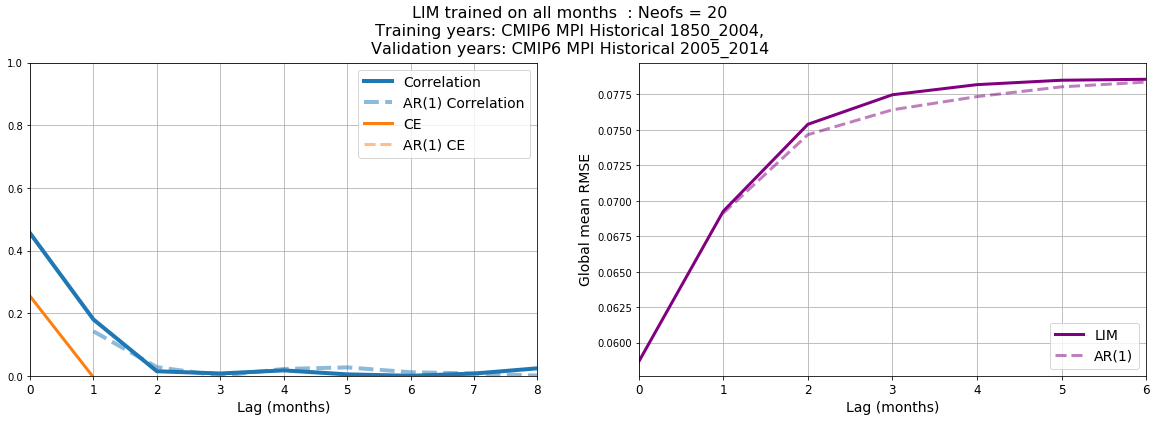

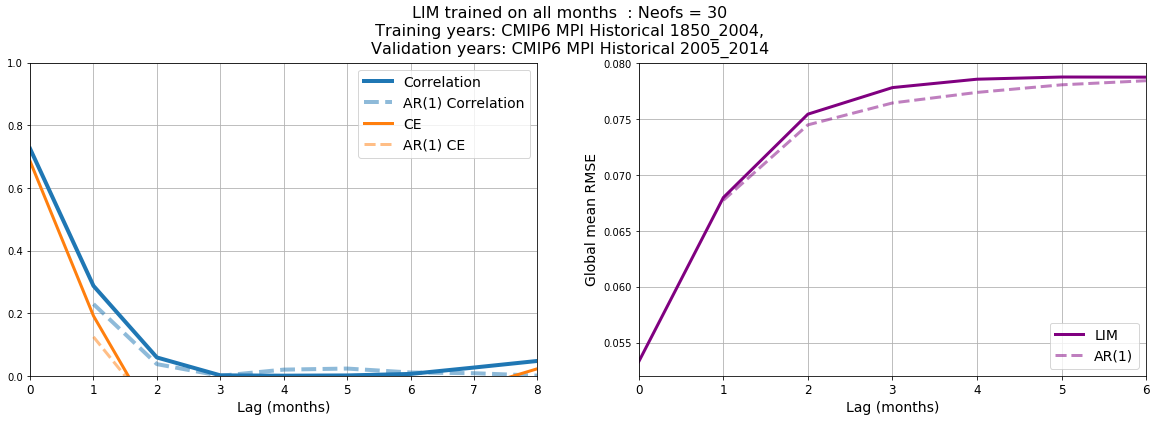

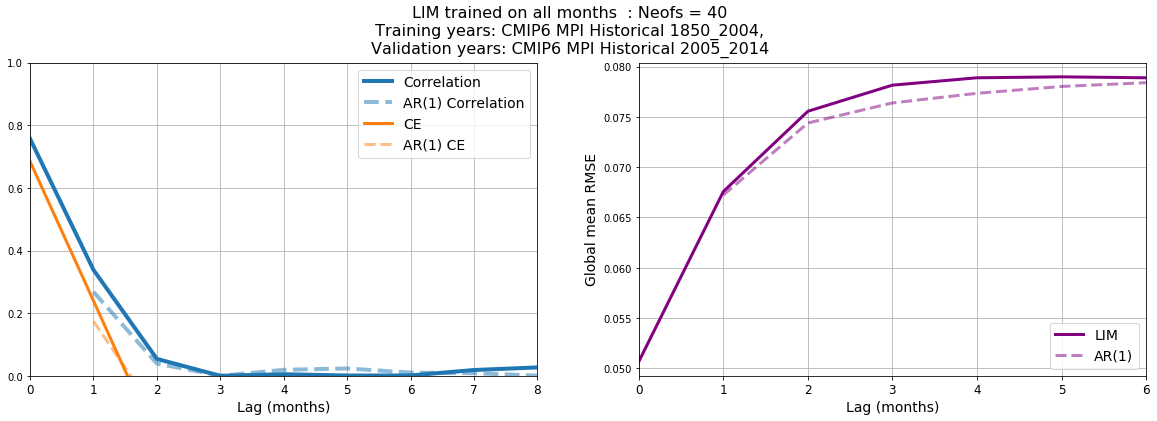

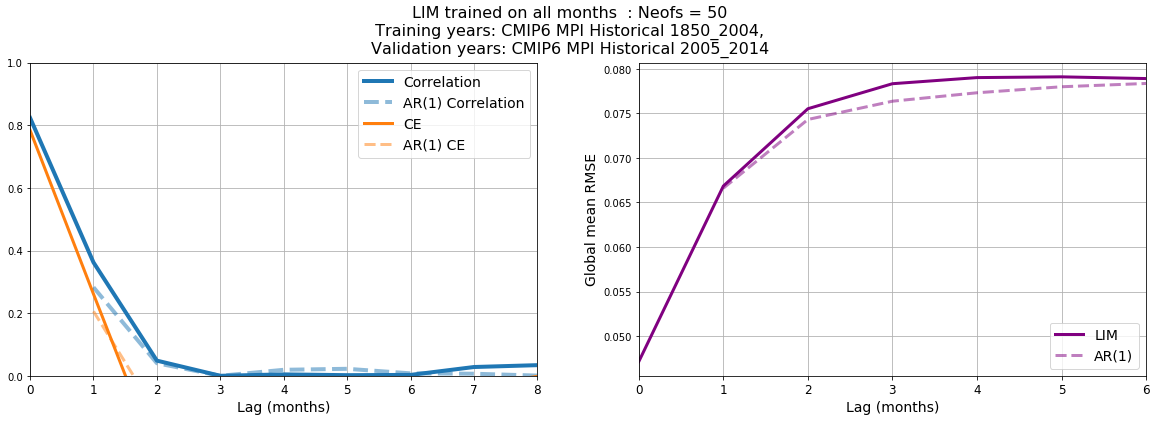

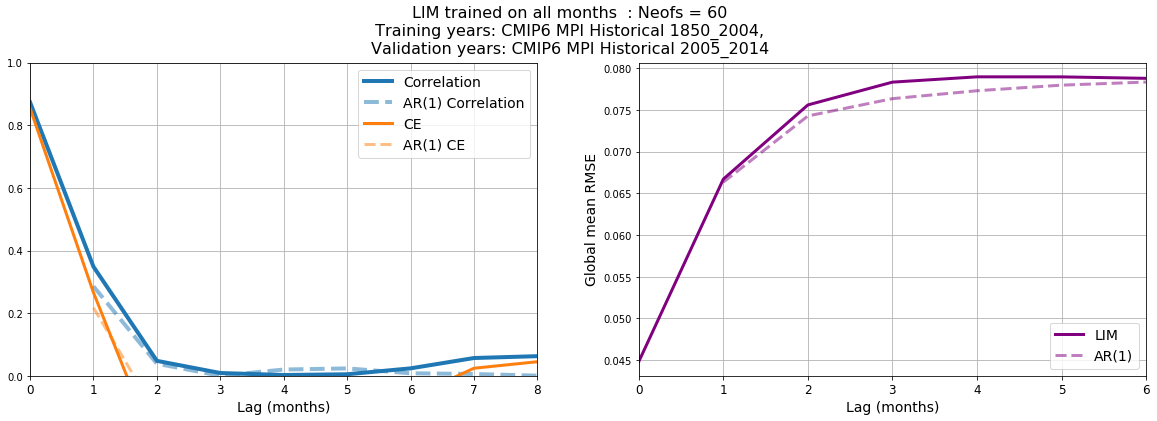

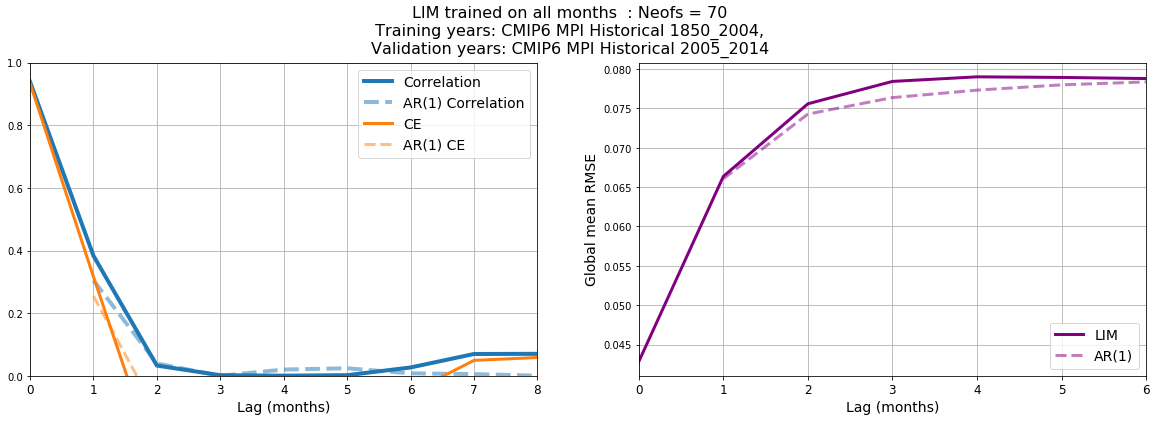

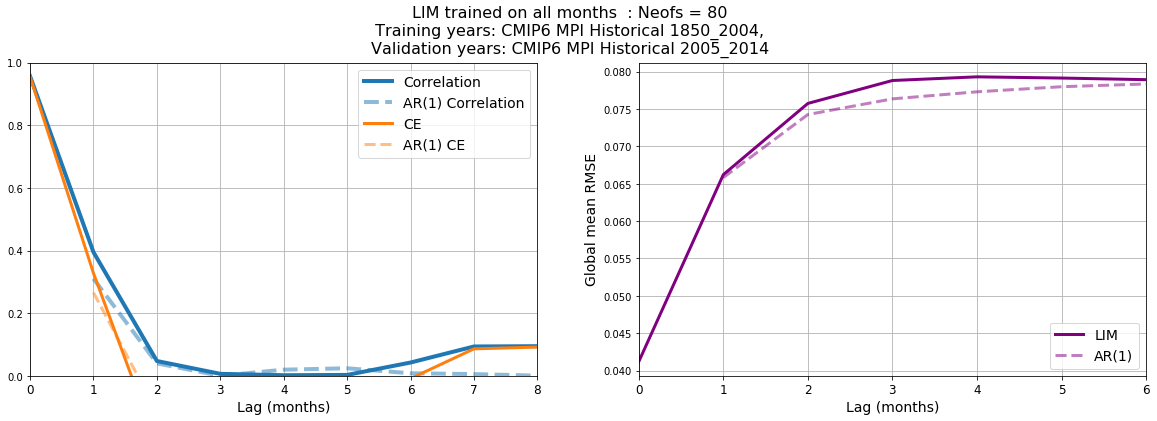

In [30]:
for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    #folder = 'reanalysis/'
    #filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
    #             '_'+date_of_interest+'.pkl')
    folder='historical/'
    filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tas'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    LIMd = experiment['LIMd']
    forecast_validation = experiment['forecast_validation']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast = experiment['ar1cast']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------
    
    fig,axs = plt.subplots(1,2,figsize=(20,6))
    
    ax = axs.flatten()

    
    plot_lagged_performance_1var(fig,ax[0],'sic',forecast_validation_lags,ar1cast_lags,
                                 tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                 wt_addin, tr_addin)
    plot_monthly_performance_1var(fig,ax[1],'sic',forecast_validation_lags,ar1cast_lags,
                                  tcmip, vcmip, valid_yrs_str, texp, vexp, tmod, vmod, 
                                  wt_addin, tr_addin)
    

    if exp_setup['Insamp']==True:     
        plt.suptitle(('LIM trained on all months: Neofs = '+str(ntrunc)+'\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                     ', Validation years: Historical'), fontsize=16)
    else: 
        plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': Neofs = '+str(ntrunc)+'\n Training years: '+
                      tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                      vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

    ax[0].legend(loc='upper right', fontsize=14)
    ax[0].set_xlabel('Lag (months)', fontsize=14)
    
    ax[1].legend(loc='lower right', fontsize=14)
    ax[1].set_xlabel('Lag (months)', fontsize=14)
    ax[1].set_ylabel('Global mean RMSE', fontsize=14)

    plt.subplots_adjust(top=0.85)

In [31]:
ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1]

array([1.97930909, 2.0169851 , 2.03042743, 2.0361203 , 2.04682796,
       2.05620893, 2.06581453, 2.07221075])

In [34]:
ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1],

(array([0.06582864, 0.07426831, 0.07636343, 0.07730882, 0.07798959,
        0.07835723, 0.07853537, 0.0787019 ]),)

In [99]:
1/len(nmodes_sic_list)

0.09090909090909091

In [51]:
#colors = ['royalblue','purple', 'c', 'orange', 'green','navy','sienna','grey','k']

cmap = matplotlib.cm.get_cmap('plasma')

move = 1/len(nmodes_sic_list)
colors = [cmap(i) for i in np.arange(0.0,1.1,move)]

Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2020_sic5_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2020_sic10_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic20_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic30_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic40_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic50_20211102.pkl


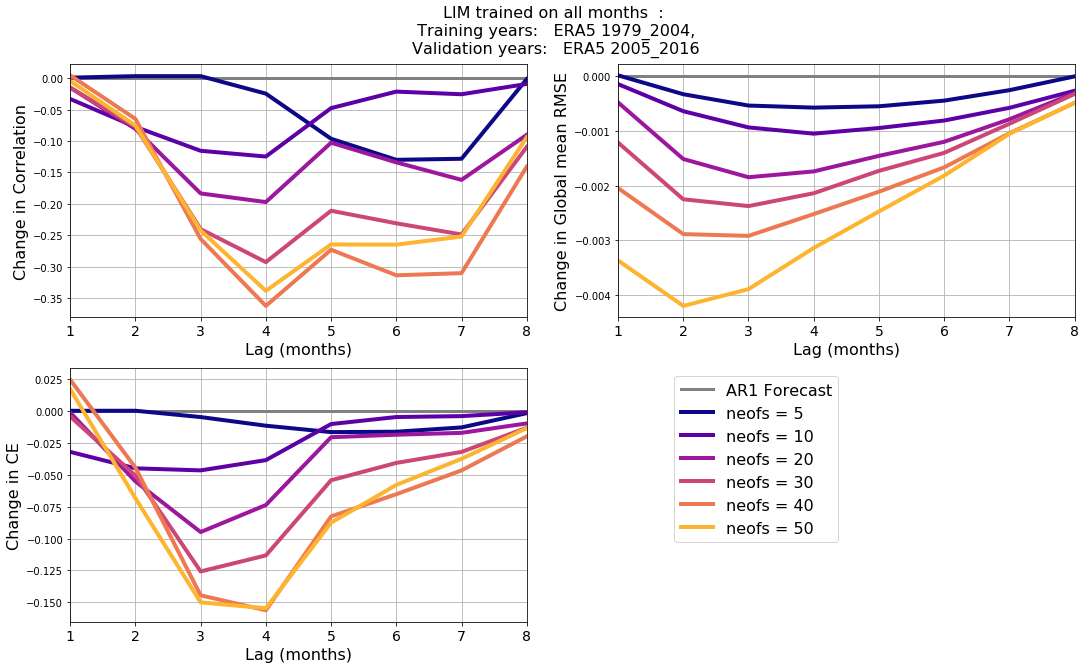

In [52]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

#     folder = 'historical/'
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'reanalysis/'
    if n<2:
        filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
                    '_'+date_of_interest+'.pkl')
    else: 
        filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
                '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

    print('Loading '+folder+filename)

    experiment =  pickle.load(open(folder+filename, 'rb'))
    
    exp_setup = experiment['forecast']['exp_setup']
    forecast = experiment['forecast']
    forecast_validation_lags = experiment['forecast_validation_lags']
    ar1cast_lags = experiment['ar1cast_lags']
    
    [tcmip, vcmip, valid_yrs_str, texp, 
     vexp, tmod, vmod, wt_addin, tr_addin] = get_title_strings(var,exp_setup,forecast)
    
    ar1_corr = ar1cast_lags['validation_stats_ar1_lags']['sic']['corr_tot'][:-1]
    ar1_ce = ar1cast_lags['validation_stats_ar1_lags']['sic']['ce_tot'][:-1]
    ar1_gm_rmse = ar1cast_lags['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    corr_diff = forecast_validation_lags['validation_stats_lags']['sic']['corr_tot'][1:] - ar1_corr
    ce_diff = forecast_validation_lags['validation_stats_lags']['sic']['ce_tot'][1:] - ar1_ce
    rmse_diff = ar1_gm_rmse - forecast_validation_lags['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[0].plot(exp_setup['lags'][1:],corr_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup['lags'][1:],ce_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[1].plot(exp_setup['lags'][1:],rmse_diff,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    

ax[1].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[1].set_yticklabels(np.arange(-0.00041,0.00041,0.0002),fontsize=14)
#ax[1].set_ylim(-0.0001,0.003)
#ax[1].set_ylim(-0.00005,0.00005)
ax[1].set_xlim(1,8)
ax[1].grid(axis='both')

# ax[0].set_xticks(np.arange(0,8,1))
ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[0].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[0].set_ylim(-0.5,0.5)
#ax[0].set_ylim(-0.25,0.25)
ax[0].set_xlim(1,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
#ax[2].set_yticklabels(np.arange(-0.21,0.21,0.1),fontsize=14)
#ax[2].set_ylim(-0.5,0.5)
#ax[2].set_ylim(-0.25,0.25)
ax[2].set_xlim(1,8)
ax[2].grid(axis='both')

# ax[3].xaxis.set_visible(False) 
# ax[3].yaxis.set_visible(False)
ax[3].axis('off')
    
if exp_setup['Insamp']==True:     
    plt.suptitle(('LIM trained on all months:\n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+': \n Training years: '+
                  tcmip+' '+tmod+' '+texp+' '+exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+
                  vcmip+' '+vmod+' '+vexp+' '+valid_yrs_str), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Correlation', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in CE', fontsize=16)

#ax[3].legend(loc='upper left', fontsize=14)
ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)
ax[1].set_xlabel('Lag (months)', fontsize=16)
ax[1].set_ylabel('Change in Global mean RMSE', fontsize=16)

plt.subplots_adjust(top=0.90)

In [54]:
ntrunc_list = [20,30,40,50] # EOF truncation for individual fields (reduced-state space)
nmodes_sic_list = [20,30,40,50]

Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic20_20211102.pkl 
    and reanalysis/Validation_era5_ntrain_1979_2004_validyrs_1980_1995_sic20_20211102.pkl


/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic30_20211102.pkl 
    and reanalysis/Validation_era5_ntrain_1979_2004_validyrs_1980_1995_sic30_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic40_20211102.pkl 
    and reanalysis/Validation_era5_ntrain_1979_2004_validyrs_1980_1995_sic40_20211102.pkl
Loading reanalysis/Validation_era5_ntrain_1979_2004_validyrs_2005_2016_sic50_20211102.pkl 
    and reanalysis/Validation_era5_ntrain_1979_2004_validyrs_1980_1995_sic50_20211102.pkl


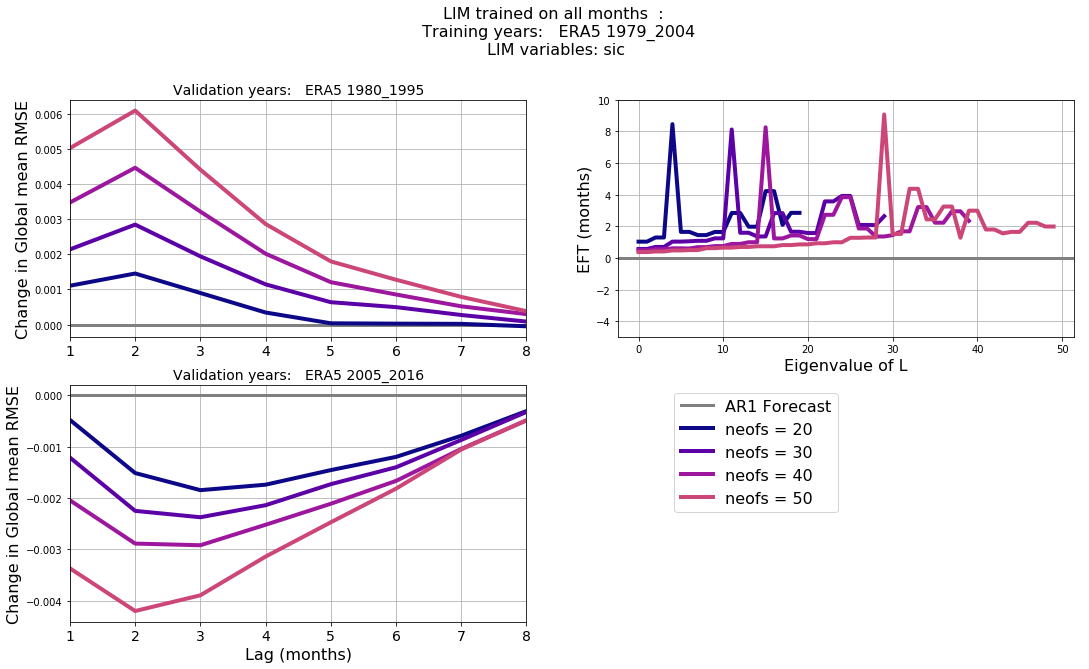

In [56]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='AR1 Forecast')
ax[2].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')
ax[1].axhline(0.0, color='gray', linewidth=3,label='AR1 Forecast')

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

    folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     if n <2:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)+
#                   '_'+date_of_interest+'.pkl')
#     else:
#         filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#                       '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                         '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'reanalysis/'
    filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
                '_'+date_of_interest+'.pkl')
    filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
                '_'+date_of_interest+'.pkl')

    print('Loading '+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(folder+filename_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    ar1_gm_rmse_is = ar1cast_lags_is['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]
    ar1_gm_rmse_os = ar1cast_lags_os['validation_stats_ar1_lags']['sic']['gm_rmse'][:-1]

    rmse_diff_is = ar1_gm_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = ar1_gm_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    

ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
ax[1].set_ylim(-5,10)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip_is+' '+tmod_is+' '+texp_is+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

## Results relative to 'sic' only: 

Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_tos20_sit20_sic20_20211102.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos20_sit20_sic20_20211102.pkl


/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_tos30_sit30_sic30_20211102.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos30_sit30_sic30_20211102.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_tos40_sit40_sic40_20211102.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos40_sit40_sic40_20211102.pkl
Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_tos50_sit50_sic50_20211102.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_tos50_sit50_sic50_20211102.pkl


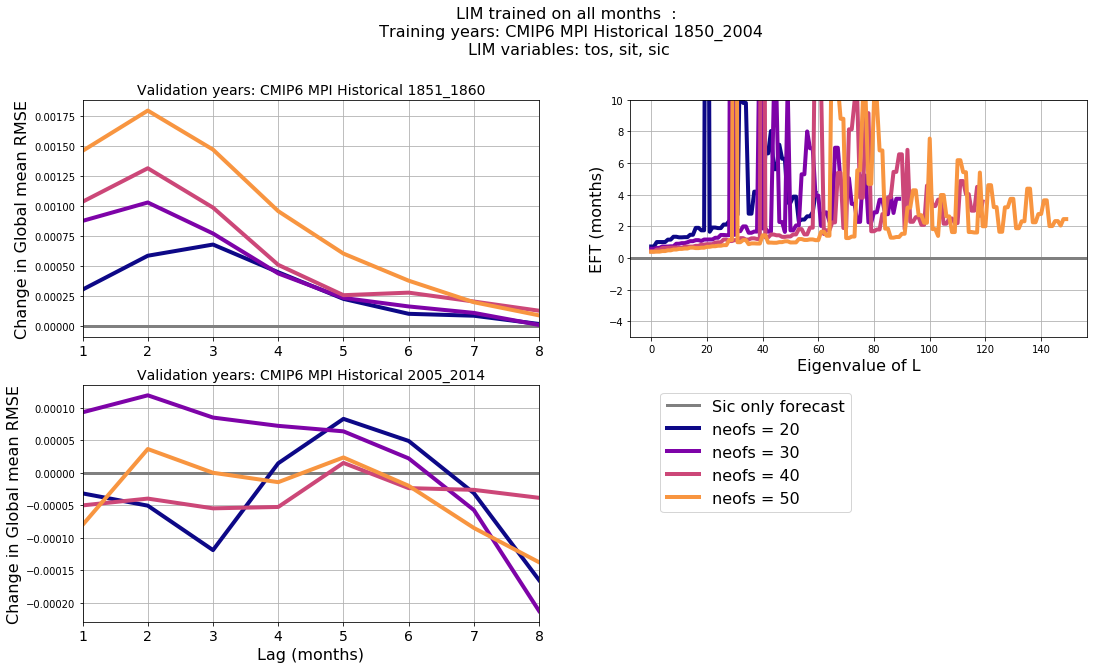

In [41]:
fig,axs = plt.subplots(2,2,figsize=(18,10))
ax = axs.flatten()

ax[0].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[2].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')
ax[1].axhline(0.0, color='gray', linewidth=3, label='Sic only forecast')

for n,ntrunc in enumerate(ntrunc_list):
    ntrunc_sic = nmodes_sic_list[n]
    var = limvars[0]

#     folder = 'historical/'
# #     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
# #                 '_'+date_of_interest+'.pkl')
# #     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
# #               '_'+date_of_interest+'.pkl')
#     filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     if n<2:
# #         filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_tos'+str(ntrunc_sic)+
# #                     '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
# #     else: 
#     filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_tos'+str(ntrunc_sic)+
#                 '_sit'+str(ntrunc_sic)+'_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
    
#     filename_sic_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_tos'+str(ntrunc_sic)+
#                     '_sic'+str(ntrunc_sic) +'_20211102.pkl')
# #     if n<2:
# #          filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1875_sic'+str(ntrunc_sic)
# #                         +'_20211102.pkl')
# #     else:
#     filename_sic_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)
#                         +'_20211102.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
    
    folder = 'reanalysis/'
    filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_tos'+str(ntrunc_sic)+
                       '_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')
    filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_tos'+str(ntrunc_sic)+
                       '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

    filename_sic_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')
    filename_sic_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
                      '_'+date_of_interest+'.pkl')

    print('Loading '+folder+filename_os+ ' \n    and '+folder+filename_is)
    

    experiment_os =  pickle.load(open(folder+filename_os, 'rb'))
    experiment_is =  pickle.load(open(folder+filename_is, 'rb'))
    
    experiment_sic_os =  pickle.load(open(folder+filename_sic_os, 'rb'))
    experiment_sic_is =  pickle.load(open(folder+filename_sic_is, 'rb'))
    
    LIMd_is = experiment_is['LIMd']
    exp_setup_is = experiment_is['forecast']['exp_setup']
    forecast_is = experiment_is['forecast']
    forecast_validation_lags_is = experiment_is['forecast_validation_lags']
    ar1cast_lags_is = experiment_is['ar1cast_lags']
    
    exp_setup_os = experiment_os['forecast']['exp_setup']
    forecast_os = experiment_os['forecast']
    forecast_validation_lags_os = experiment_os['forecast_validation_lags']
    ar1cast_lags_os = experiment_os['ar1cast_lags']
    
    exp_setup_sic_is = experiment_sic_is['forecast']['exp_setup']
    forecast_sic_is = experiment_sic_is['forecast']
    forecast_validation_lags_sic_is = experiment_sic_is['forecast_validation_lags']
    ar1cast_lags_sic_is = experiment_sic_is['ar1cast_lags']
    
    exp_setup_sic_os = experiment_sic_os['forecast']['exp_setup']
    forecast_sic_os = experiment_sic_os['forecast']
    forecast_validation_lags_sic_os = experiment_sic_os['forecast_validation_lags']
    ar1cast_lags_sic_os = experiment_sic_os['ar1cast_lags']
    
    [tcmip_is, vcmip_is, valid_yrs_str_is, texp_is, 
     vexp_is, tmod_is, vmod_is, wt_addin_is, tr_addin_is] = get_title_strings(var,exp_setup_is,forecast_is)
    [tcmip_os, vcmip_os, valid_yrs_str_os, texp_os, 
     vexp_os, tmod_os, vmod_os, wt_addin_os, tr_addin_os] = get_title_strings(var,exp_setup_os,forecast_os)
    
    sic_only_rmse_is = forecast_validation_lags_sic_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    sic_only_rmse_os = forecast_validation_lags_sic_os['validation_stats_lags']['sic']['gm_rmse'][1:]

    rmse_diff_is = sic_only_rmse_is - forecast_validation_lags_is['validation_stats_lags']['sic']['gm_rmse'][1:]
    rmse_diff_os = sic_only_rmse_os - forecast_validation_lags_os['validation_stats_lags']['sic']['gm_rmse'][1:]
    
    ##---------------------------------------------
    ## PLOT CORR/CE PERFORMANCE: 
    ##---------------------------------------------

    ax[1].plot(-1/(LIMd_is['lam_L']),linewidth=4.0, color=colors[n])
    ax[0].plot(exp_setup_is['lags'][1:],rmse_diff_is,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    ax[2].plot(exp_setup_os['lags'][1:],rmse_diff_os,label=('neofs = '+str(ntrunc)),linewidth=4.0, color=colors[n])
    

ax[0].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[0].set_xlim(1,8)
ax[0].grid(axis='both')

ax[2].set_xticklabels(np.arange(1,18,1),fontsize=14)
ax[2].set_xlim(1,8)
ax[2].grid(axis='both')

ax[1].grid(axis='both')
ax[1].set_ylim(-5,10)

ax[3].axis('off')

title_is = ('Validation years: '+vcmip_is+' '+vmod_is+' '+vexp_is+' '+valid_yrs_str_is)
title_os = ('Validation years: '+vcmip_os+' '+vmod_os+' '+vexp_os+' '+valid_yrs_str_os)

ax[0].set_title(title_is, fontsize=14)
ax[2].set_title(title_os, fontsize=14)
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)

#ax[0].legend(loc='upper right', fontsize=14)
#ax[0].set_xlabel('Lag (months)', fontsize=16)
ax[0].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[1].set_xlabel('Eigenvalue of L', fontsize=16)
ax[1].set_ylabel('EFT (months)', fontsize=16)

ax[2].set_xlabel('Lag (months)', fontsize=16)
ax[2].set_ylabel('Change in Global mean RMSE', fontsize=16)

ax[2].legend(bbox_to_anchor=(0.7,0,1,1), fontsize=16)

plt.subplots_adjust(top=0.85)

## Spatial Performance: 

In [146]:
def load_validation_data(var, exp_setup, remove_climo=True, detrend=True, verbose=True):
    ## LOad Truth data: 
    fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    v = {}
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
    #        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    if tecut <=0: 
        tecut = False
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=remove_climo, detrend=detrend, 
                               verbose=verbose,tscut=int(exp_setup['nyears_startvalid']/12), 
                               tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var = X_var/100
    
    return X_var

In [147]:
def calc_validation_stats_spatial(lag_int,var,X_var,exp_setup,forecast,LIMd):
    ## Calculate validation statistics: 
    [truth_anom, 
     forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup['mo'],X_var,
                                                            forecast['x_forecast_dcomp'],
                                                            LIMd_is['var_dict'],insamp=exp_setup['Insamp'])


    print('Truth_anom shape: '+str(truth_anom.shape))
    print('Forecast_anom shape: '+str(forecast_anom.shape))

    corr=np.zeros(truth_anom.shape[0])
    ce=np.zeros(truth_anom.shape[0])

    for i in range(truth_anom.shape[0]):
        corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
        ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))

    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

    corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
    
    return corr_2d, ce_2d, rmse_2d

In [160]:
def plot_spatial_validation(ax, variable, lat, lon, title): 

        ax.set_title(title, fontsize=16)
        ax.coastlines()

        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([-180, 180, 55, 90], ccrs.PlateCarree())

        cf = ax.pcolormesh(lon,lat, variable ,cmap='RdBu_r', 
                           transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
        fig.colorbar(cf, ax=ax)
        
        return 

In [163]:
n = 6 
ntrunc = ntrunc_list[n]
ntrunc_sic = nmodes_sic_list[n]
var = 'sic'
lag_int = 1

In [164]:
folder = 'historical/'
#     filename_os = ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_sic'+str(ntrunc_sic)+
#               '_'+date_of_interest+'.pkl')
filename_os =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_2005_2014_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')
filename_is =  ('Validation_'+model+'_ntrain_1850_2004_validyrs_1851_1860_psl'+str(ntrunc_sic)+
                '_sic'+str(ntrunc_sic)+'_'+date_of_interest+'.pkl')

#     folder = 'satellite/'
#     filename_os = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2016_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename_is = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_2004_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

#    folder = 'reanalysis/'
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_2005_2020_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')
#     filename = ('Validation_'+model+'_ntrain_1979_2004_validyrs_1980_1995_sic'+str(ntrunc_sic)+
#                 '_'+date_of_interest+'.pkl')

print('Loading '+folder+filename_os+ ' \n    and '+folder+filename_is)

experiment_os =  pickle.load(open(folder+filename_os, 'rb'))
experiment_is =  pickle.load(open(folder+filename_is, 'rb'))

LIMd_is = experiment_is['LIMd']
exp_setup_is = experiment_is['forecast']['exp_setup']
forecast_is = experiment_is['forecast']
forecast_validation_lags_is = experiment_is['forecast_validation_lags']
ar1cast_lags_is = experiment_is['ar1cast_lags']

Loading historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_2005_2014_psl80_sic80_20211027.pkl 
    and historical/Validation_cmip6_mpi_hist_ntrain_1850_2004_validyrs_1851_1860_psl80_sic80_20211027.pkl


In [168]:
X_var = load_validation_data(var, exp_setup_is, remove_climo=True, detrend=True, verbose=True)

tecut = 11, tscut = 1.0
Loading from sic
Loading from _SImon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 1860
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with ze

In [170]:
[corr_2d, ce_2d, rmse_2d] = calc_validation_stats_spatial(lag_int,var,X_var,exp_setup_is,forecast_is,LIMd_is)

modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import matplotlib.path as mpath

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    plot_spatial_validation(ax[i], mode, LIMd_is['var_dict'][var]['lat'], 
                            LIMd_is['var_dict'][var]['lon'], mode_name[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

In [143]:
## LOad Truth data: 

fdic_valid = limkb.build_training_dic(exp_setup_is['valid_dsource'])
v = {}
tecut = int(exp_setup_is['nyears_startvalid']/12)+(exp_setup_is['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup_is['nyears_startvalid']/12))

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup_is['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup_is['lat_cutoff'])
        
if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

tecut = 11, tscut = 1.0
Loading from sic
Loading from _SImon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 1860
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with ze

In [173]:
X_var

In [171]:
## Calculate validation statistics: 
[truth_anom, 
 forecast_anom] = limbuild.gather_truth_forecast_notime(lag_int,var,exp_setup_is['mo'],X_var,
                                                        forecast_is['x_forecast_dcomp'],
                                                        LIMd_is['var_dict'],insamp=exp_setup_is['Insamp'])


print('Truth_anom shape: '+str(truth_anom.shape))
print('Forecast_anom shape: '+str(forecast_anom.shape))

corr=np.zeros(truth_anom.shape[0])
ce=np.zeros(truth_anom.shape[0])

for i in range(truth_anom.shape[0]):
    corr[i] = np.corrcoef(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))[0,1]
    ce[i] = LMR_utils.coefficient_efficiency(truth_anom[i,:],np.nan_to_num(forecast_anom[i,:]))
    
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd_is['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))

corr_2d = np.reshape(corr,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
ce_2d = np.reshape(ce,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))
rmse_2d = np.reshape(rmse,(LIMd_is['var_dict'][var]['lat'].shape[0],LIMd_is['var_dict'][var]['lat'].shape[1]))

AttributeError: 'NoneType' object has no attribute 'shape'

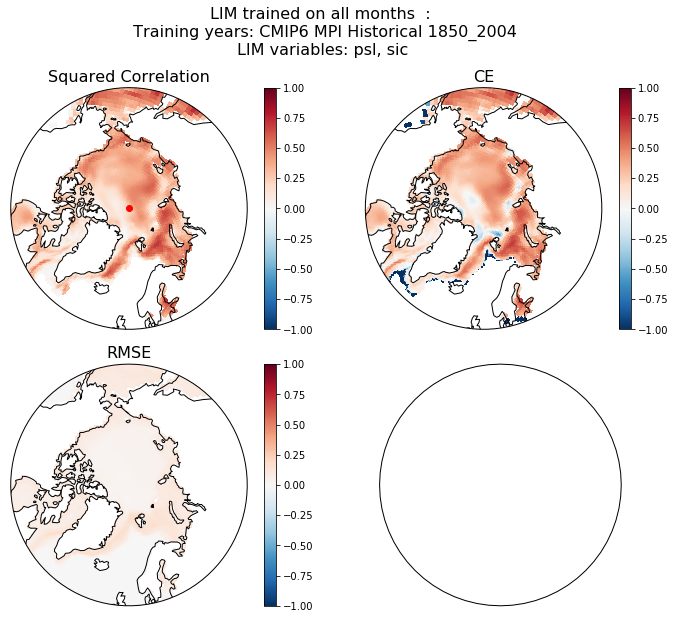

In [145]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          mode,cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

#ax[0].scatter(lon_plot,lat_plot,color='r')

### inf values in forecast?

In [112]:
sic_forecast = forecast_is['x_forecast_dcomp'][lag_int,LIMd_is['var_dict'][var]['var_inds'],lag_int:]
sic_forecast_2d = np.reshape(sic_forecast,(103,256,119))

In [124]:
np.where(np.isinf(sic_forecast_2d[:,:,0]))

(array([0, 0, 0, ..., 7, 7, 7]), array([ 0,  1,  2, ..., 20, 21, 22]))

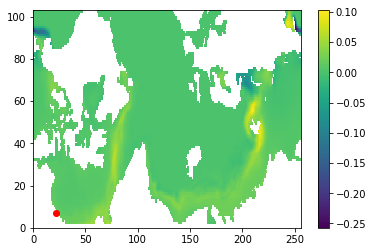

In [125]:
lat_plot = 7
lon_plot = 22

plt.pcolormesh(sic_forecast_2d[:,:,0])
plt.colorbar()
plt.scatter(lon_plot,lat_plot,color='r')

In [121]:
sic_forecast_2d[lat_plot,lon_plot,0]

inf

In [135]:
np.reshape(X_var,(103,256,120))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan])

In [131]:
np.reshape(truth_anom,(103,256,119))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [130]:
np.reshape(forecast_anom,(103,256,119))[lat_plot,lon_plot,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [128]:
sic_forecast_2d[lat_plot,lon_plot,:]

array([-inf, -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf, -inf,
       -inf, -inf,  inf, -inf, -inf,  inf,  inf, -inf, -inf, -inf,  inf,
       -inf, -inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf,  inf,  inf,
       -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf,  inf,  inf,  inf,
        inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf, -inf,
       -inf,  inf,  inf,  inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,
       -inf,  inf, -inf,  inf,  inf,  inf, -inf,  inf,  inf,  inf, -inf,
        inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,  inf,  inf,  inf,
       -inf, -inf,  inf,  inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf,  inf, -inf, -inf,  inf,  inf,
       -inf, -inf,  inf,  inf,  inf, -inf,  inf,  inf,  inf])

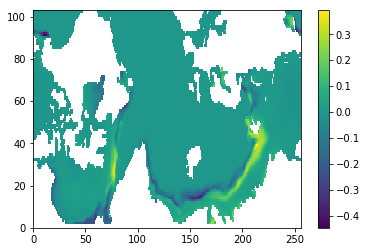

In [137]:
plt.pcolormesh(np.reshape(X_var,(103,256,120))[:,:,0])
plt.colorbar()

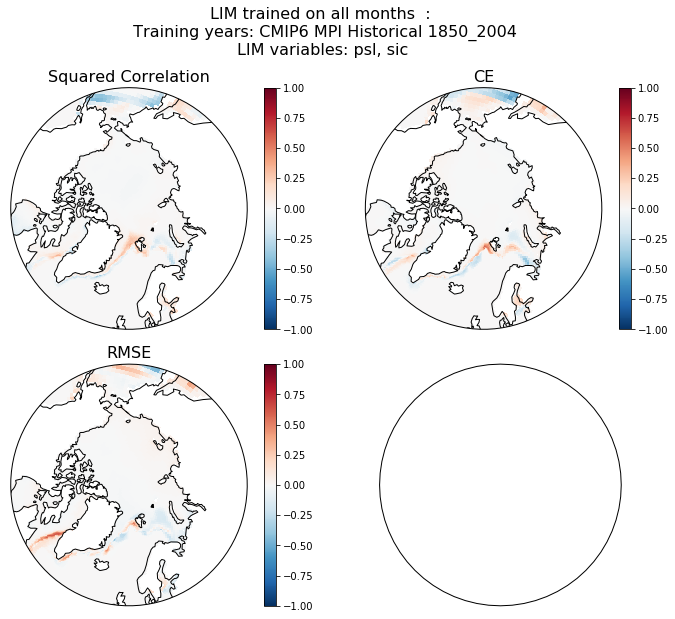

In [139]:
import matplotlib.path as mpath
modes = [corr_2d**2,ce_2d,rmse_2d]
mode_name = ['Squared Correlation','CE', 'RMSE']

fig, axs = plt.subplots(2,2,figsize=(10,9),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,mode in enumerate(modes):
    ax[i].set_title(mode_name[i], fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 55, 90], ccrs.PlateCarree())
    
    cf = ax[i].pcolormesh(LIMd_is['var_dict'][var]['lon'],#*lat_mask, #[:,:,0],
                          LIMd_is['var_dict'][var]['lat'],#*lat_mask, #[:,:,0],
                          np.reshape(X_var,(103,256,120))[:,:,i],cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-1,vmax=1)
    fig.colorbar(cf, ax=ax[i])
    
plt.suptitle(('LIM trained on all months'+wt_addin_is+tr_addin_is+': \n Training years: '+
              tcmip+' '+tmod+' '+texp+' '+exp_setup_is['mod_sic_filename'][-22:-13]+
              '\nLIM variables: '+(", ").join(limvars)), fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])
